In [10]:
import sys
dirname = '/Users/m.daffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.surrogate_models import (
    KRG, 
    MixIntKernelType,
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
    )

from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
    )


from sklearn.metrics import mean_squared_error

from smt.explainability_tools import PartialDependenceDisplay, PDFeatureImportanceDisplay
from smt.explainability_tools import partial_dependence, pd_feature_importance

import matplotlib.pyplot as plt
import time

In [28]:
"""Problem definition"""
# Design space
ds = DesignSpace(
     [
         CategoricalVariable(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]),
         FloatVariable(10.0, 20.0),
         FloatVariable(1.0, 2.0),
     ]
 )
# Objective function
def y(X):
    listI = [
        0.0833,
        0.139,
        0.380,
        0.0796,
        0.133,
        0.363,
        0.0859,
        0.136,
        0.360,
        0.0922,
        0.138,
        0.369,
        ]
    
    I = np.int64(X[0])
    L = X[1]
    S = X[2]
    Ival = listI[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * Ival)

    return y

f_obj = y

# Create training and testing data
n_data = 200
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)
inverse_categories_map = {0: {i: f"{i+1}" for i in range(12)}}

"""Modelling"""
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    
        )
start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")


run time (s): 8.740340232849121
RMSE: 0.0001
rRMSE: 0.0553


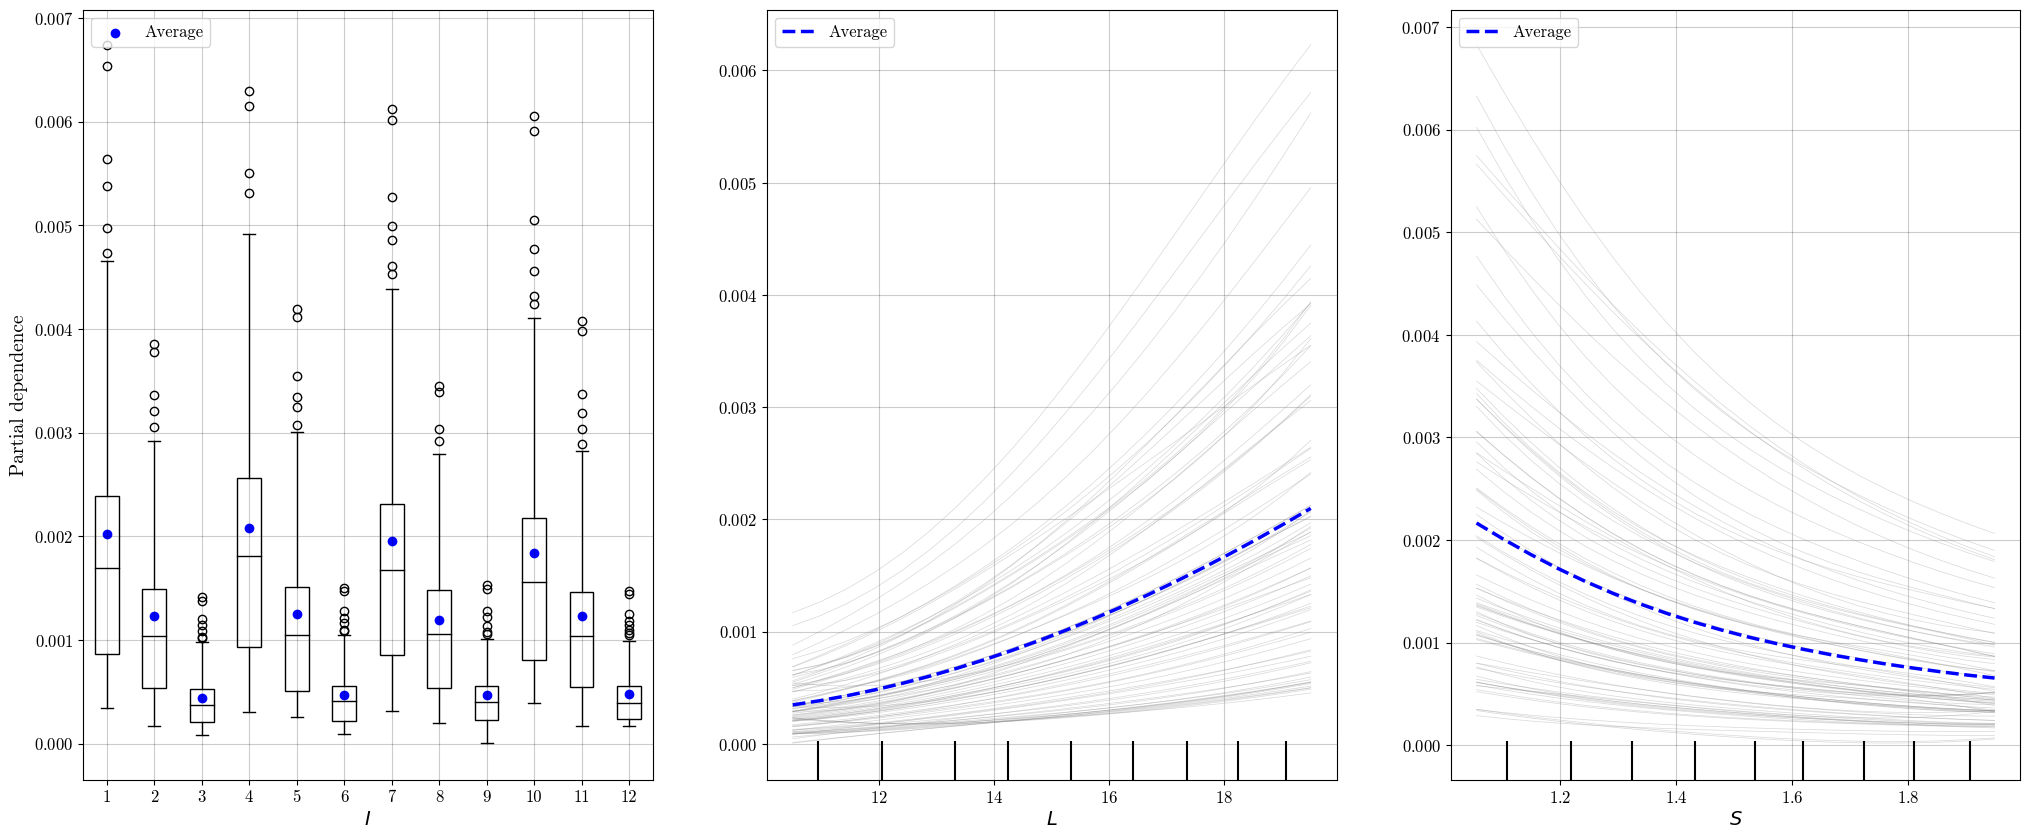

In [33]:
model = sm
X = X_tr
feature_names = [
    r'$I$', 
    r'$L$', 
    r'$S$', 
    ]

features = [0, 1, 2,]
categorical_features = [0,]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.5,
    centered=False,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )

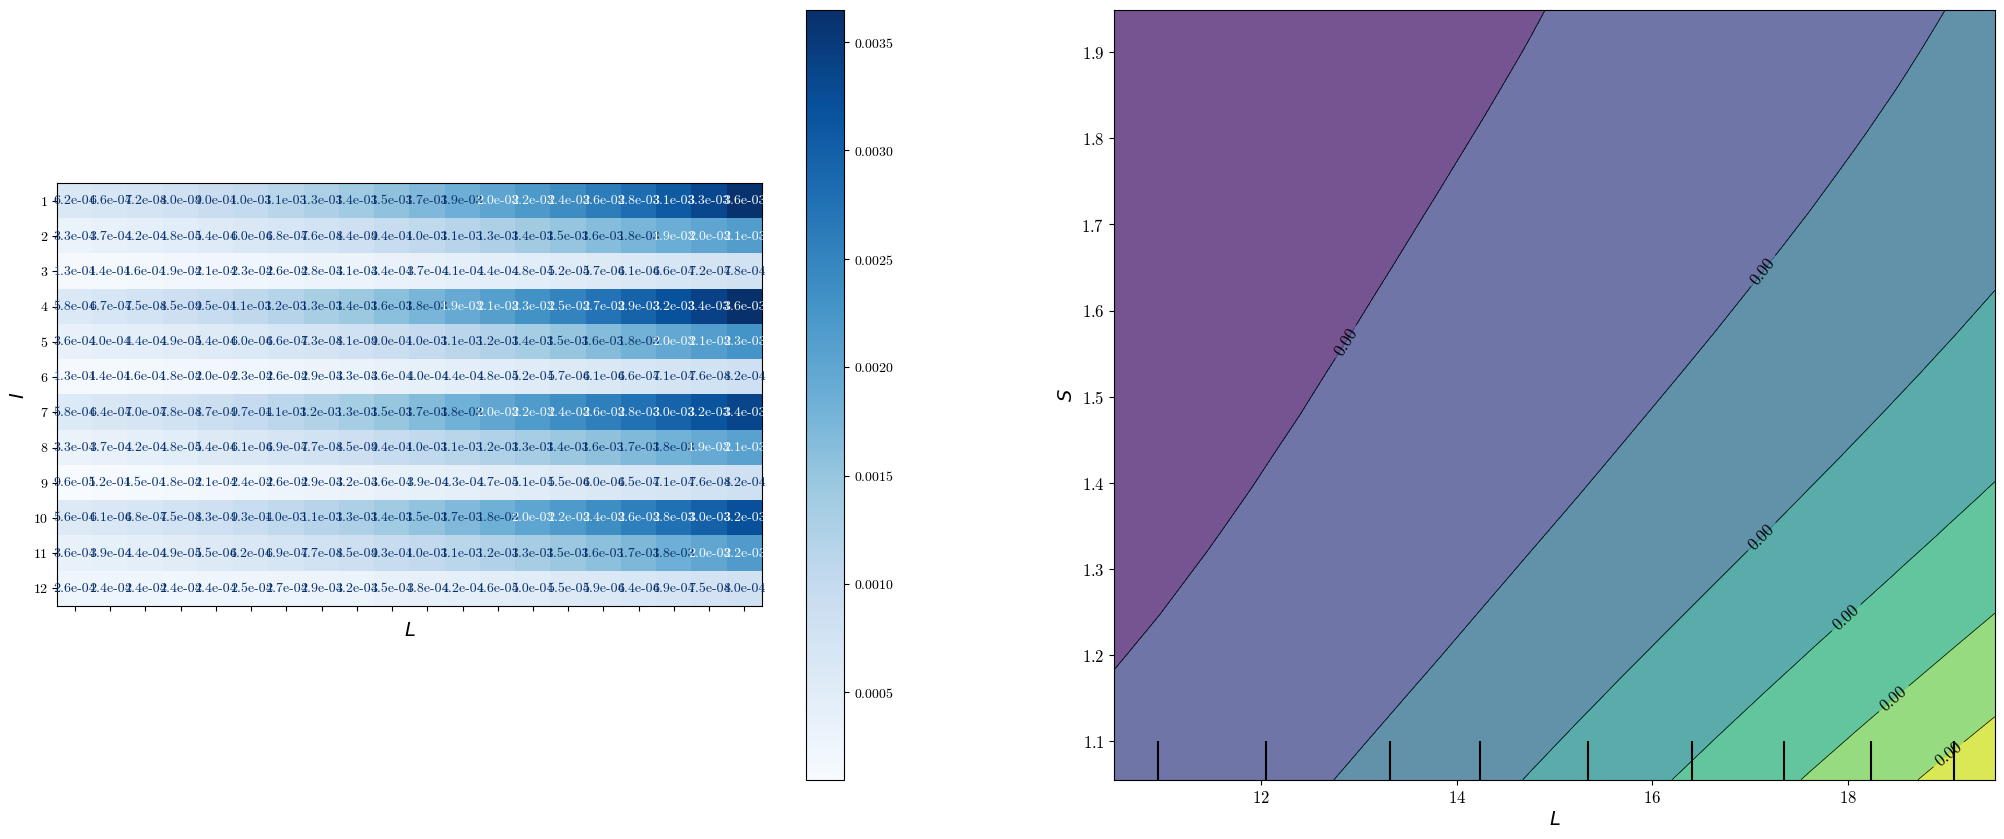

In [34]:
model = sm
X = X_tr
feature_names = [
    r'$I$', 
    r'$L$', 
    r'$S$', 
    ]

features = [(0, 1), (1, 2,)]
categorical_features = [0,]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    ratio_samples = 0.25,
    centered=False,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )